# Scope of the Report

This report is going to use the closing prices of 7 different market data (Gold, Platinum, Silver, Dow Jones Index, Euro, Yen, and Yuan) as below table to predict the closing price of Gold in the future. 

The model which will be used to predict the target value is Multiple Layer Perceptron (MLP) regressor.

For this report except the last Section, only one hidden layer will be added to the model. Also, all the neurons are fully connected i.e., Dense Layers will be used. Meanwhile, several parameters will be tuned such as number of hidden layer neuron, number of epoch, and batch size, to find out the best MLP regressor model.

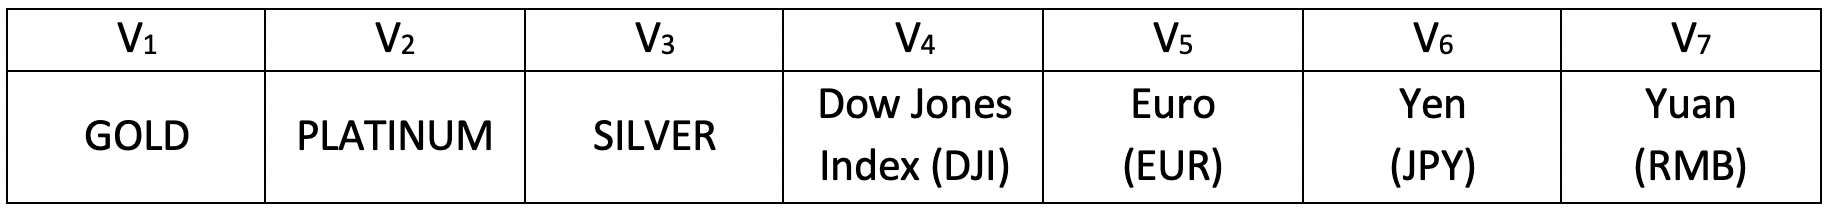

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load required packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import time
import tensorflow as tf
from itertools import product
import seaborn as sns

In [3]:
# Preset some parameters
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams.update({'font.size': 16})
seed = 2022

## Data Preprocessing

In [4]:
# Stock of interest
price_of_interest = ["GOLD", "PLATINUM", "SILVER", "DJI", "EUR", "JPY", "RMB"]

In [5]:
# Load the time series price of each stock to separate data frame
for i in price_of_interest:
  globals()[i] = pd.read_csv('/content/gdrive/MyDrive/MATH 6373/Homework 1/Data Set/' + i + '.csv')

# Check example
GOLD.head()

,Date,Close
0,12/31/18,1281.3
1,12/28/18,1283.0
2,12/27/18,1281.1
3,12/26/18,1273.0
4,12/24/18,1271.8


In [6]:
print("Total data point in the time series data:", GOLD.shape[0])

Total data point in the time series data: 1006


The target is to predict “GOLD (V1)” price on day “t+1” based on closing price of all 7 market data from day t to day t-4. Thus, each data point will contain a feature vector with dimension of 35 as below
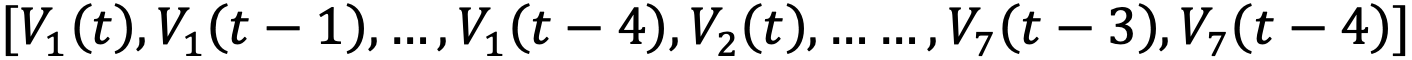

Thus, there will be 1001 data point. Below image shows that each row represents the feature of each data point.

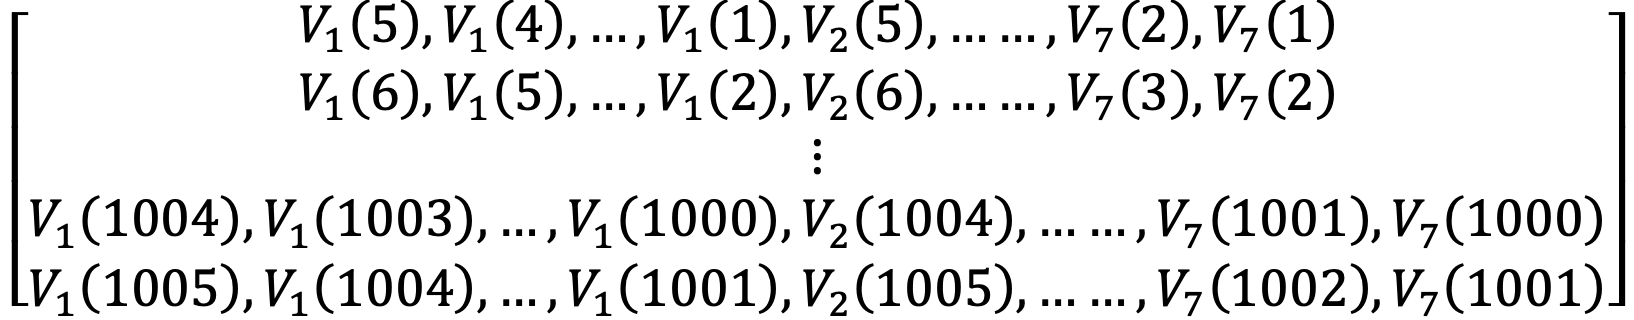

In [7]:
df = pd.DataFrame()
for j in range(4, len(GOLD)-1):
  temp = None
  for i in price_of_interest:
    temp = pd.concat([temp, globals()[i].loc[range(j-4, j+1), "Close"][::-1]])
  df = pd.concat([df, pd.DataFrame(temp.values, index = range(1, 36), columns = [j]).T])

df.head()

,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,31,32,33,34,35
4,1271.8,1273.0,1281.1,1283.0,1281.3,787.5,798.5,796.5,791.5,796.5,...,111.054001,110.402000,111.206001,110.855003,110.330002,6.9054,6.8983,6.8981,6.8653,6.8772
5,1258.1,1271.8,1273.0,1281.1,1283.0,789.5,787.5,798.5,796.5,791.5,...,111.170998,111.054001,110.402000,111.206001,110.855003,6.8841,6.9054,6.8983,6.8981,6.8653
6,1267.9,1258.1,1271.8,1273.0,1281.1,795.5,789.5,787.5,798.5,796.5,...,112.410004,111.170998,111.054001,110.402000,111.206001,6.8910,6.8841,6.9054,6.8983,6.8981
7,1256.4,1267.9,1258.1,1271.8,1273.0,785.5,795.5,789.5,787.5,798.5,...,112.524002,112.410004,111.170998,111.054001,110.402000,6.8942,6.8910,6.8841,6.9054,6.8983
8,1253.6,1256.4,1267.9,1258.1,1271.8,793.5,785.5,795.5,789.5,787.5,...,112.829002,112.524002,112.410004,111.170998,111.054001,6.8962,6.8942,6.8910,6.8841,6.9054


The target value of each data point is as below.

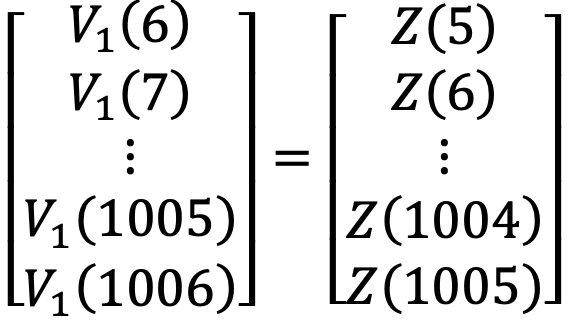

### Target value vector

In [8]:
Z = GOLD.loc[range(5, len(GOLD)), "Close"]
Z.name = "Z"
Z.index = range(4, len(GOLD)-1)
Z.head()

4    1258.1
5    1267.9
6    1256.4
7    1253.6
8    1251.8
Name: Z, dtype: float64

### Final combined data set

In [9]:
final_df = pd.concat([Z, df], axis = 1)
final_df.head()

,Z,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
4,1258.1,1271.8,1273.0,1281.1,1283.0,1281.3,787.5,798.5,796.5,791.5,...,111.054001,110.402000,111.206001,110.855003,110.330002,6.9054,6.8983,6.8981,6.8653,6.8772
5,1267.9,1258.1,1271.8,1273.0,1281.1,1283.0,789.5,787.5,798.5,796.5,...,111.170998,111.054001,110.402000,111.206001,110.855003,6.8841,6.9054,6.8983,6.8981,6.8653
6,1256.4,1267.9,1258.1,1271.8,1273.0,1281.1,795.5,789.5,787.5,798.5,...,112.410004,111.170998,111.054001,110.402000,111.206001,6.8910,6.8841,6.9054,6.8983,6.8981
7,1253.6,1256.4,1267.9,1258.1,1271.8,1273.0,785.5,795.5,789.5,787.5,...,112.524002,112.410004,111.170998,111.054001,110.402000,6.8942,6.8910,6.8841,6.9054,6.8983
8,1251.8,1253.6,1256.4,1267.9,1258.1,1271.8,793.5,785.5,795.5,789.5,...,112.829002,112.524002,112.410004,111.170998,111.054001,6.8962,6.8942,6.8910,6.8841,6.9054


## Visualize the trend of each Stock Price versus RMB

In [10]:
for i in price_of_interest:
  temp_mean = round(globals()[i]["Close"].mean(), 2)
  globals()["mean_"+i] = temp_mean
  print("Mean of", i, "=", temp_mean)

Mean of GOLD = 1235.63
Mean of PLATINUM = 968.4
Mean of SILVER = 16.4
Mean of DJI = 20573.96
Mean of EUR = 0.88
Mean of JPY = 113.08
Mean of RMB = 6.57


y-axis represents the price (Vj) divided by mean price of each market data (Mj) respectively.

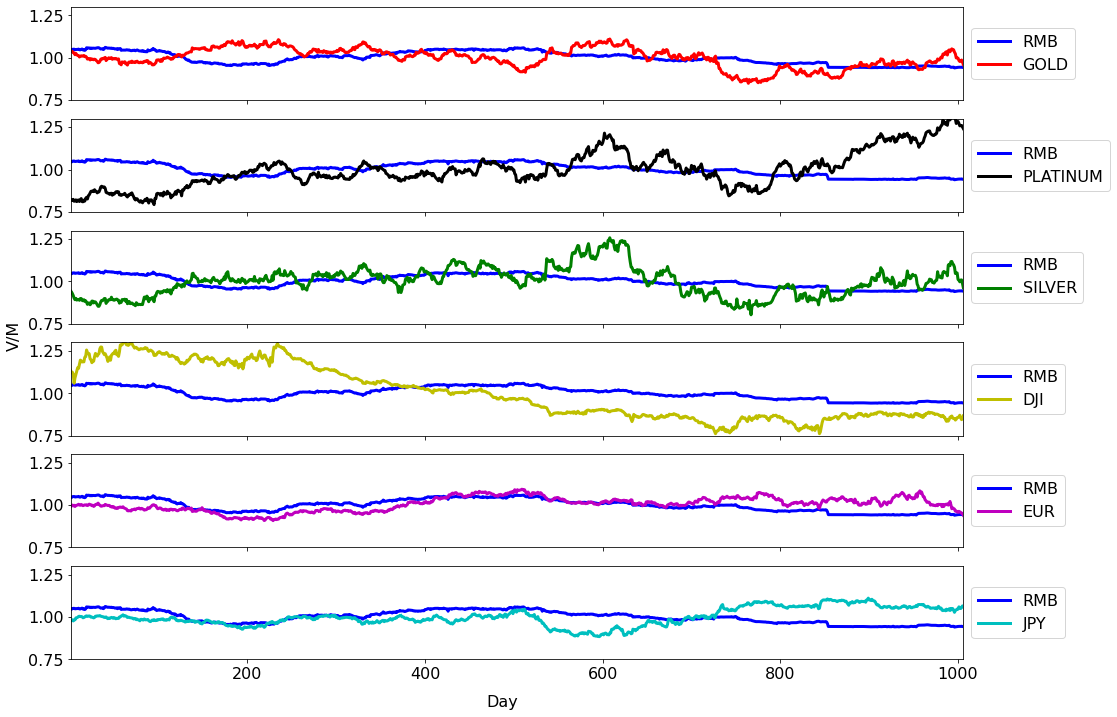

In [11]:
V7_div_M7 = RMB["Close"] / mean_RMB
col_list = ["r", "k", "g", "y", "m", "c"]

fig, ax = plt.subplots(6, 1, sharex = True)
for i in range(6):
  temp_1 = globals()[price_of_interest[i]]["Close"] / globals()["mean_"+price_of_interest[i]]
  ax[i].plot(range(1,len(RMB)+1), V7_div_M7, color = "blue", label = "RMB", linewidth = 3)
  ax[i].plot(range(1,len(RMB)+1), temp_1, color = col_list[i], label = price_of_interest[i], linewidth = 3)
  ax[i].legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
  ax[i].set_xlim(1, len(RMB))
  ax[i].set_ylim(0.75, 1.3)

fig.text(0.5, 0.07, "Day", ha = "center")
fig.text(0.07, 0.5, "V/M", va = "center", rotation = "vertical")
plt.show()

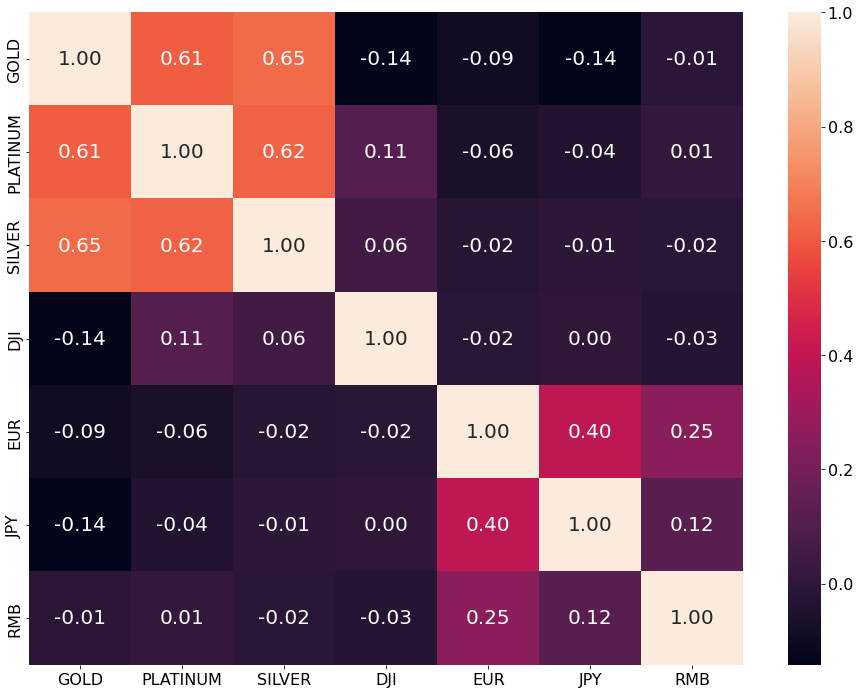

In [12]:
# Shows the correlation between each market
all_raw_data = pd.concat([GOLD["Close"].pct_change()[1:], PLATINUM["Close"].pct_change()[1:], SILVER["Close"].pct_change()[1:], DJI["Close"].pct_change()[1:],
                          EUR["Close"].pct_change()[1:], JPY["Close"].pct_change()[1:], RMB["Close"].pct_change()[1:]], axis = 1)
all_raw_data.columns = price_of_interest
corr_all_raw_data = all_raw_data.corr()
sns.heatmap(corr_all_raw_data, annot = True, fmt = ".2f", annot_kws = {"size": 20})
plt.show()

## Rate of return of the stock price

Since each market data has quite different scale of value, it would be more reasonable to replace the price with the rate of return. 

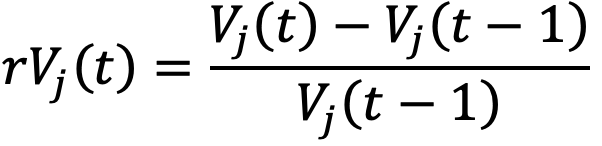

Since there is no rate of return for day 1, one more data point will be eliminated, which will leave 1000 data point.

Convert all the 1000 data points into rate of return.

In [13]:
r_df = pd.DataFrame()
for j in range(4, len(GOLD)-2):
  temp = None
  for i in price_of_interest:
    temp = pd.concat([temp, globals()[i]["Close"].pct_change()[1:].iloc[range(j-4, j+1)][::-1]])
  r_df = pd.concat([r_df, pd.DataFrame(temp.values, index = range(1, 36), columns = [j+1]).T])

r_df.head()

,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,31,32,33,34,35
5,-0.010772,-0.000943,-0.006323,-0.001481,0.001327,0.002540,-0.013776,0.002511,0.006317,-0.006277,...,0.001054,0.005906,-0.007230,0.003166,0.004758,-0.003085,0.001029,0.000029,0.004778,-0.001730
6,0.007790,-0.010772,-0.000943,-0.006323,-0.001481,0.007600,0.002540,-0.013776,0.002511,0.006317,...,0.011145,0.001054,0.005906,-0.007230,0.003166,0.001002,-0.003085,0.001029,0.000029,0.004778
7,-0.009070,0.007790,-0.010772,-0.000943,-0.006323,-0.012571,0.007600,0.002540,-0.013776,0.002511,...,0.001014,0.011145,0.001054,0.005906,-0.007230,0.000464,0.001002,-0.003085,0.001029,0.000029
8,-0.002229,-0.009070,0.007790,-0.010772,-0.000943,0.010185,-0.012571,0.007600,0.002540,-0.013776,...,0.002711,0.001014,0.011145,0.001054,0.005906,0.000290,0.000464,0.001002,-0.003085,0.001029
9,-0.001436,-0.002229,-0.009070,0.007790,-0.010772,0.001890,0.010185,-0.012571,0.007600,0.002540,...,0.004972,0.002711,0.001014,0.011145,0.001054,0.001508,0.000290,0.000464,0.001002,-0.003085


Convert all the 1000 target values into rate of return.

In [14]:
r_Z = Z.pct_change()[1:]
r_Z.name = "r_Z"
r_Z.index = r_df.index
r_Z.head()

5    0.007790
6   -0.009070
7   -0.002229
8   -0.001436
9   -0.008308
Name: r_Z, dtype: float64

Combine both data points and target values to get final data frame.

In [15]:
final_r_df = pd.concat([r_Z, r_df], axis = 1)
final_r_df.head()

,r_Z,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
5,0.007790,-0.010772,-0.000943,-0.006323,-0.001481,0.001327,0.002540,-0.013776,0.002511,0.006317,...,0.001054,0.005906,-0.007230,0.003166,0.004758,-0.003085,0.001029,0.000029,0.004778,-0.001730
6,-0.009070,0.007790,-0.010772,-0.000943,-0.006323,-0.001481,0.007600,0.002540,-0.013776,0.002511,...,0.011145,0.001054,0.005906,-0.007230,0.003166,0.001002,-0.003085,0.001029,0.000029,0.004778
7,-0.002229,-0.009070,0.007790,-0.010772,-0.000943,-0.006323,-0.012571,0.007600,0.002540,-0.013776,...,0.001014,0.011145,0.001054,0.005906,-0.007230,0.000464,0.001002,-0.003085,0.001029,0.000029
8,-0.001436,-0.002229,-0.009070,0.007790,-0.010772,-0.000943,0.010185,-0.012571,0.007600,0.002540,...,0.002711,0.001014,0.011145,0.001054,0.005906,0.000290,0.000464,0.001002,-0.003085,0.001029
9,-0.008308,-0.001436,-0.002229,-0.009070,0.007790,-0.010772,0.001890,0.010185,-0.012571,0.007600,...,0.004972,0.002711,0.001014,0.011145,0.001054,0.001508,0.000290,0.000464,0.001002,-0.003085


Calculate the mean of target value of performance evaluation later.

In [16]:
mean_r_Z = abs(r_Z).mean()
mean_r_Z

0.0061284160804519405

## Visualize the rate of return of each stock and compare to the target stock, Gold.

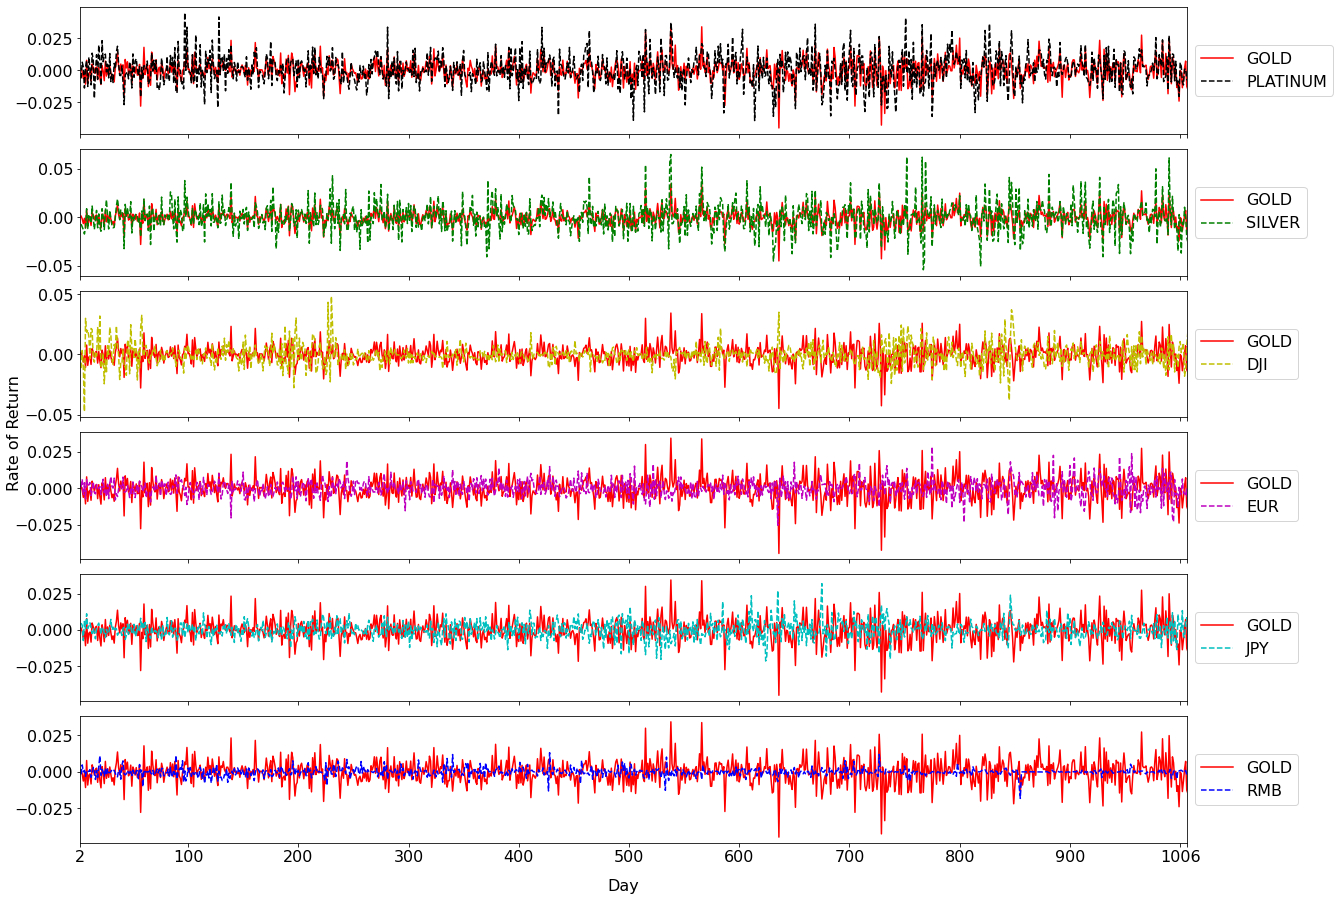

In [17]:
col_list = ["k", "g", "y", "m", "c","b"]

fig, ax = plt.subplots(6, 1, sharex = True)
fig.tight_layout(pad = 0)
for i in range(6):
  temp_1 = globals()["GOLD"]["Close"].pct_change()[1:]
  temp_2 = globals()[price_of_interest[i+1]]["Close"].pct_change()[1:] 
  ax[i].plot(temp_1, color = "r", label = "GOLD")
  ax[i].plot(temp_2, color = col_list[i], label = price_of_interest[i+1], ls = "--")
  ax[i].legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
  ax[i].set_xlim(0, 1004)
  ax[i].set_xticklabels([2, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1006])
  ax[i].set_xticks([0, 98, 198, 298, 398, 498, 598, 698, 798, 898, 998, 1004])

fig.text(0.5, -0.03, "Day", ha = "center")
fig.text(-0.035, 0.5, "Rate of Return", va = "center", rotation = "vertical")
plt.show()

# Parsimony Principle

One of the most important things for MLP model is to determine the number of neurons of each layer. Fortunately, there is a parsimony principle: 

>>> number of parameter ≤ amount of information in the training set

The desired model will have 35 input features, h neurons in hidden layer and 1 output. 

The total number of parameters will consist of the 35 × h￼weights connecting the input layer to the hidden layer (W(j, k)), a line vector of thresholds with dimension of h for each neuron in the hidden layer (Bj), a line vector of weights with dimension of h connecting the hidden layer to the output layer (m(1,j)) as well as 1 output threshold (C). 

This will give the formula param(h) i.e., # of parameter as below

>>> param(h) = 35h + h + h + 1 = 37h + 1
￼

# Data Spliting and Neuron Number Determination

Use 80-20 split method will give 800 training cases and 200 test cases. 

In [18]:
df_value = final_r_df.values

Y = df_value[:, 0]
X = df_value[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 20220210)

TRN = len(X_train)
TST = len(X_test)
print("Number of case in training set:", TRN)
print("Number of case in test set:", TST)

Number of case in training set: 800
Number of case in test set: 200


Apply the number of training case as the amount of information in the training set to the parsimony principal formula will give h = 21

37h + 1 < 800

⇒ h < 799/37 = 21.59

# Learning Process

## Define the function which calculate the norm of the gradient in order to check the learning process.

In [19]:
# Calculate the norm of gradient
def GradNorm(grads):
  w = grads[0].numpy()
  w = w.flatten()
  for i in range(1, 4): # related to number of hidden layer.  
    w1 = grads[i].numpy()
    w = np.append(w, w1.flatten())

  return np.linalg.norm(w)

## Define the function of Mulitple Layer Perceptron.
Input:
1. Optimizer
2. Activation Function
3. Number of hidden layer
4. Batch Size
5. Number of Epochs
6. Feature of Training Set
7. True value of Training Set
8. Feautre of Test Set
9. True value of Test Set

Output:
1. MSE of Training Set for each batch
2. MSE of Test Set for each batch
3. Norm of Gradient
4. Terminal Weights and Bias
5. Computational Time
6. Total Number of Batches
7. Terminal MSE of Training Set
8. MSE of Training Set for each epoch
9. MSE of Test Set for each epoch

Note that 
1. Loss Function is MSE and all the MSE is calculated based on entire training set and test set.
2. Activation function is ReLU
3. Optimizer is Adam

In [20]:
def MLP(optimizer, activation, layer_n, h, batch_size, epochs, X_train, y_train, X_test, y_test):
  model = Sequential()
  model.add(Dense(h[0], input_shape = (35,), activation = activation))
  if layer_n != 1:
    for i in range(1, layer_n):
      model.add(Dense(h[i], activation = activation))
  model.add(Dense(1, activation = 'linear'))
  #model.summary()

  optimizer = optimizer
  loss = tf.keras.losses.MeanSquaredError()

  trainMSE_batch, testMSE_batch, trainMSE_epoch, testMSE_epoch, normgrad, total_batch = [], [], [], [], [], 0
  start_time = time.time()
  for epoch in range(epochs):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size = 1024).batch(batch_size)
    # Iterate over the batches of the dataset.
    for batch, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        total_batch += 1
        # Open a GradientTape to record the operations run during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer. The operations that the layer applies to its inputs are going to be recorded on the GradientTape.
            logit_train = model(x_batch_train, training = True)
            # Compute the loss value for this batch.
            loss_train = loss(y_batch_train, logit_train)
            trainMSE_batch.append(loss_train.numpy())
            
            # Logits for this minibatch
            logit_test = model(X_test, training = False)
            # Compute the loss value of test set with respect to current parameters.
            loss_test = loss(y_test, logit_test)
            testMSE_batch.append(loss_test.numpy())

        # Use the gradient tape to automatically retrieve the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_train, model.trainable_weights)
        normgrad.append(GradNorm(grads))
        
        # Run one batch of gradient descent by updating the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Compute the terminal MSE on entire training set
    temp = model(X_train, training = False)
    loss_temp = loss(y_train, temp)
    trainMSE_epoch.append(loss_temp.numpy())

    temp = model(X_test, training = False)
    loss_temp = loss(y_test, temp)
    testMSE_epoch.append(loss_temp.numpy())

  end_time = time.time()

  # Compute the terminal MSE on entire training set 
  temp_all_train_pred = model(X_train, training = False)
  loss_final_train = loss(y_train, temp_all_train_pred)
  final_trainMSE = loss_final_train.numpy()

  return (trainMSE_batch, testMSE_batch, normgrad, model.get_weights(), round(end_time - start_time, 1), total_batch, final_trainMSE, trainMSE_epoch, testMSE_epoch)

## Hyperparameters setting

Several hyperparameters will be tested to figure out which is the best one
1. Batch Size: 20, 40, 80, 400
2. Total number of epoch: 100
3. Number of hidden layer neuron (h): 21, 63

Thus, there will be 8 models in total.

### Train the models

In [21]:
tf.random.set_seed(seed)
epoch = 100
pair_hyperpara = list(product([21, 63], [20, 40, 80, 400]))
for i in range(len(pair_hyperpara)):
  pair_num = str(i+1)
  temp = MLP(tf.keras.optimizers.Adam(), "relu", 1, [pair_hyperpara[i][0]], pair_hyperpara[i][1], epoch, X_train, y_train, X_test, y_test)
  globals()["trainMSE_batch_" + pair_num] = temp[0]
  globals()["testMSE_batch_" + pair_num] = temp[1]
  globals()["normgrad_" + pair_num] = temp[2]
  globals()["para_" + pair_num] = temp[3]
  globals()["computing_time_" + pair_num] = temp[4]
  globals()["total_batch_" + pair_num] = temp[5]
  globals()["final_trainMSE_" + pair_num] = temp[6]
  globals()["trainMSE_epoch_" + pair_num] = temp[7]
  globals()["testMSE_epoch_" + pair_num] = temp[8]
  globals()["normgrad_epoch_" + pair_num] = list()
  for j in list(range(0, len(globals()["normgrad_" + pair_num]) + 1, int(len(globals()["normgrad_" + pair_num])/epoch)))[1:]:
    globals()["normgrad_epoch_" + pair_num].append(globals()["normgrad_" + pair_num][j-1])

## Show the computational time and terminal training MSE of all 8 models

In [22]:
MLP_table = pd.DataFrame({"h": [21, 21, 21, 21, 63, 63, 63, 63], 
                         "BATS": [20, 40, 80, 400, 20, 40, 80, 400], 
                         "Computing Time (s)": [computing_time_1, computing_time_2, computing_time_3, computing_time_4, computing_time_5, computing_time_6, computing_time_7, computing_time_8], 
                         "Terminal Training MSE": [final_trainMSE_1, final_trainMSE_2, final_trainMSE_3, final_trainMSE_4, final_trainMSE_5, final_trainMSE_6, final_trainMSE_7, final_trainMSE_8]})
MLP_table.to_excel("MLP_table.xlsx")
MLP_table

,h,BATS,Computing Time (s),Terminal Training MSE
0,21,20,50.9,0.000111
1,21,40,25.4,0.000103
2,21,80,12.1,0.000099
3,21,400,4.2,0.000085
4,63,20,50.3,0.000126
5,63,40,25.2,0.000118
6,63,80,12.3,0.000112
7,63,400,3.6,0.000096


Several findings in above table.

1. BATS is strongly related to the computing time. However, h doesn’t affect computational time too much.
2. h = 21, which is given by parsimony principle does a little better terminal training MSE than h = 63. It is due to that are only 800 training cases, we don’t have a bunch of information to provide to the hidden layer.
3. Among all the 8 models, h = 21 with BATS = 400 gives the best result of terminal training MSE. 

This is not the only criteria to decide the best model. More details will be checked.

## Visualize MSE of each epoch

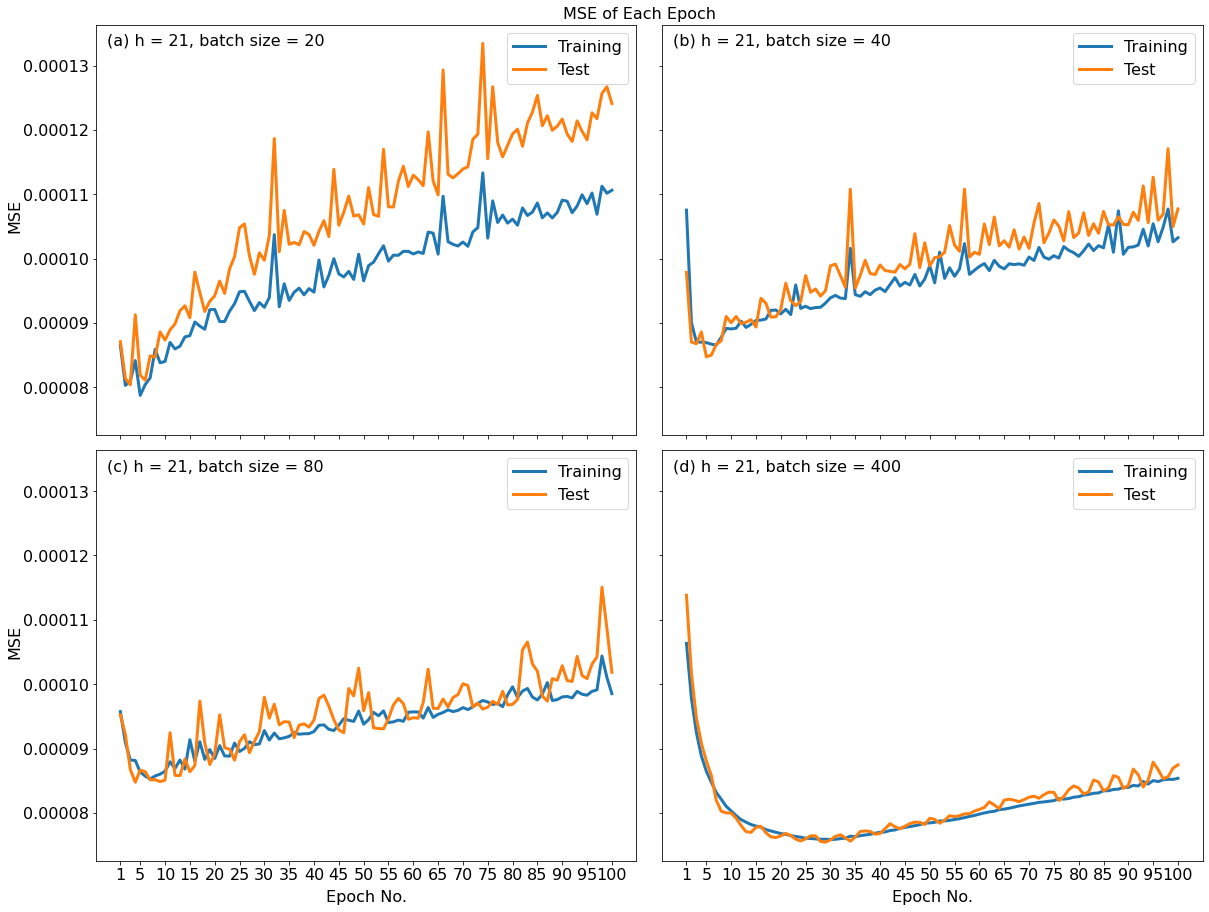

In [23]:
fig, ax = plt.subplots(2, 2, sharey = True, sharex = True)
fig.tight_layout(pad = 0)
ax[0][0].plot(trainMSE_epoch_1, label = "Training", linewidth = 3)
ax[0][0].plot(testMSE_epoch_1, label = "Test", linewidth = 3)
ax[0][0].text(0.02, 0.95, "(a) h = 21, batch size = 20", transform = ax[0][0].transAxes, ha = "left")
ax[0][0].text(-0.15, 0.5, "MSE", transform = ax[0][0].transAxes, ha = "center", rotation = "vertical")
ax[0][0].legend(loc = "upper right")

ax[0][1].plot(trainMSE_epoch_2, label = "Training", linewidth = 3)
ax[0][1].plot(testMSE_epoch_2, label = "Test", linewidth = 3)
ax[0][1].text(0.02, 0.95, "(b) h = 21, batch size = 40", transform = ax[0][1].transAxes, ha = "left")
ax[0][1].legend()

ax[1][0].plot(trainMSE_epoch_3, label = "Training", linewidth = 3)
ax[1][0].plot(testMSE_epoch_3, label = "Test", linewidth = 3)
ax[1][0].text(0.02, 0.95, "(c) h = 21, batch size = 80", transform = ax[1][0].transAxes, ha = "left")
ax[1][0].text(-0.15, 0.5, "MSE", transform = ax[1][0].transAxes, ha = "center", rotation = "vertical")
ax[1][0].text(0.5, -0.1, "Epoch No.", transform = ax[1][0].transAxes, ha = "center")
ax[1][0].legend()

ax[1][1].plot(trainMSE_epoch_4, label = "Training", linewidth = 3)
ax[1][1].plot(testMSE_epoch_4, label = "Test", linewidth = 3)
ax[1][1].text(0.02, 0.95, "(d) h = 21, batch size = 400", transform = ax[1][1].transAxes, ha = "left")
ax[1][1].text(0.5, -0.1, "Epoch No.", transform = ax[1][1].transAxes, ha = "center")
ax[1][1].set_xticks([0] + list(range(4, epoch+1, 5)))
ax[1][1].set_xticklabels([1] + list(range(5, epoch+1, 5)))
ax[1][1].legend()

fig.text(0.5, 1, "MSE of Each Epoch", ha = "center")

plt.show()

## Visualize Gradient of MSE of each epoch

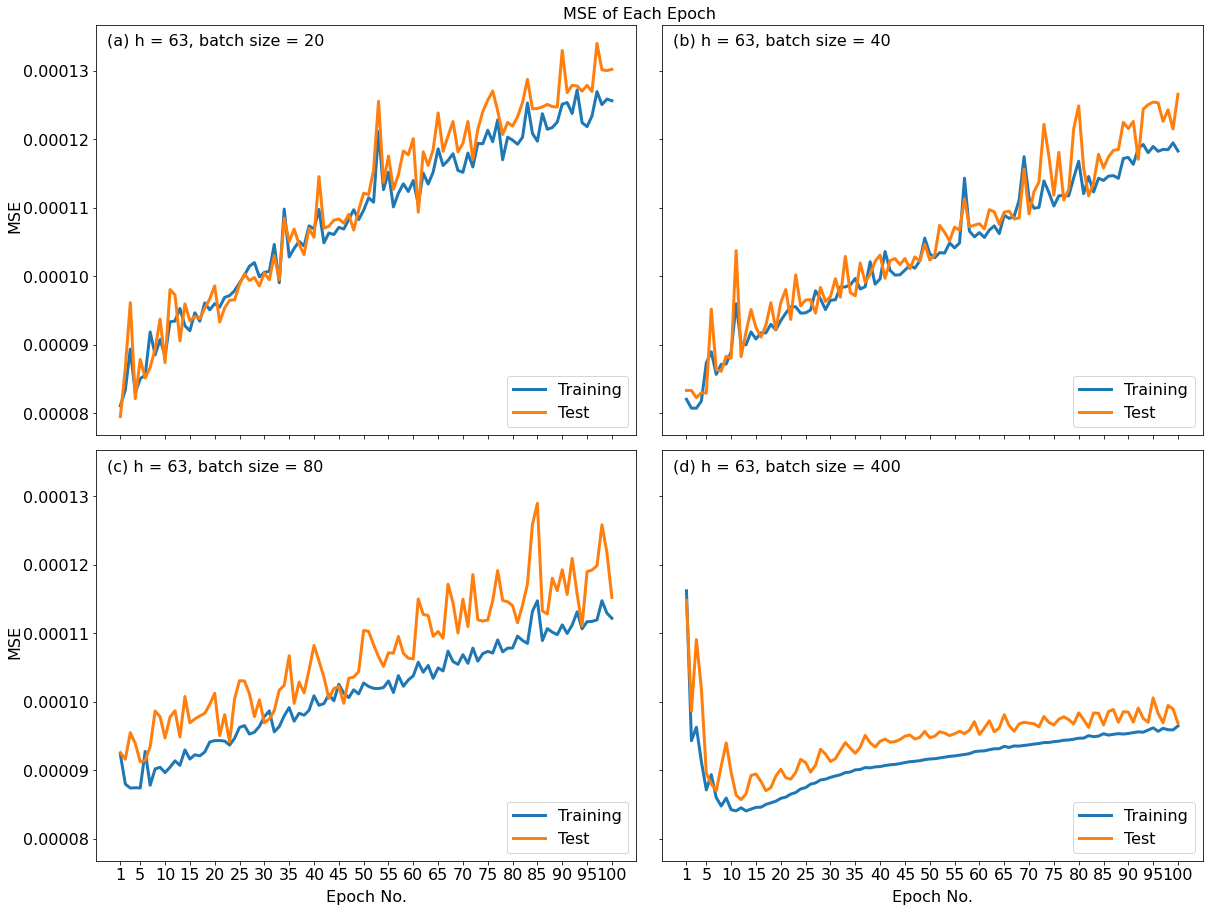

In [24]:
fig, ax = plt.subplots(2, 2, sharey = True, sharex = True)
fig.tight_layout(pad = 0)
ax[0][0].plot(trainMSE_epoch_5, label = "Training", linewidth = 3)
ax[0][0].plot(testMSE_epoch_5, label = "Test", linewidth = 3)
ax[0][0].text(0.02, 0.95, "(a) h = 63, batch size = 20", transform = ax[0][0].transAxes, ha = "left")
ax[0][0].text(-0.15, 0.5, "MSE", transform = ax[0][0].transAxes, ha = "center", rotation = "vertical")
ax[0][0].legend(loc = "lower right")

ax[0][1].plot(trainMSE_epoch_6, label = "Training", linewidth = 3)
ax[0][1].plot(testMSE_epoch_6, label = "Test", linewidth = 3)
ax[0][1].text(0.02, 0.95, "(b) h = 63, batch size = 40", transform = ax[0][1].transAxes, ha = "left")
ax[0][1].legend(loc = "lower right")

ax[1][0].plot(trainMSE_epoch_7, label = "Training", linewidth = 3)
ax[1][0].plot(testMSE_epoch_7, label = "Test", linewidth = 3)
ax[1][0].text(0.02, 0.95, "(c) h = 63, batch size = 80", transform = ax[1][0].transAxes, ha = "left")
ax[1][0].text(-0.15, 0.5, "MSE", transform = ax[1][0].transAxes, ha = "center", rotation = "vertical")
ax[1][0].text(0.5, -0.1, "Epoch No.", transform = ax[1][0].transAxes, ha = "center")
ax[1][0].legend(loc = "lower right")

ax[1][1].plot(trainMSE_epoch_8, label = "Training", linewidth = 3)
ax[1][1].plot(testMSE_epoch_8, label = "Test", linewidth = 3)
ax[1][1].text(0.02, 0.95, "(d) h = 63, batch size = 400", transform = ax[1][1].transAxes, ha = "left")
ax[1][1].text(0.5, -0.1, "Epoch No.", transform = ax[1][1].transAxes, ha = "center")
ax[1][1].set_xticks([0] + list(range(4, epoch+1, 5)))
ax[1][1].set_xticklabels([1] + list(range(5, epoch+1, 5)))
ax[1][1].legend(loc = "lower right")

fig.text(0.5, 1, "MSE of Each Epoch", ha = "center")

plt.show()

It can be observed that only the model with batch size = 400 has a trend of decreasing at the beginning and then at some point the MSE started to increase. 

It also shows more stable curve while the others fluctuate a lot between each epoch.

## Normalized Gradient MSE

To minimize MSE, gradient descent algorithm is applied. The goal is to find the weights and thresholds that ideally have grad(MSE) = 0. 

However, most of the time it is infeasible. Thus, it is preferred to have grad(MSE) as small as possible. One good value to compare between each learning is to compute the normalized gradient MSE as below

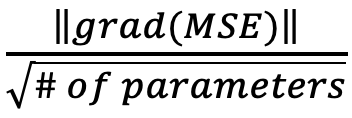

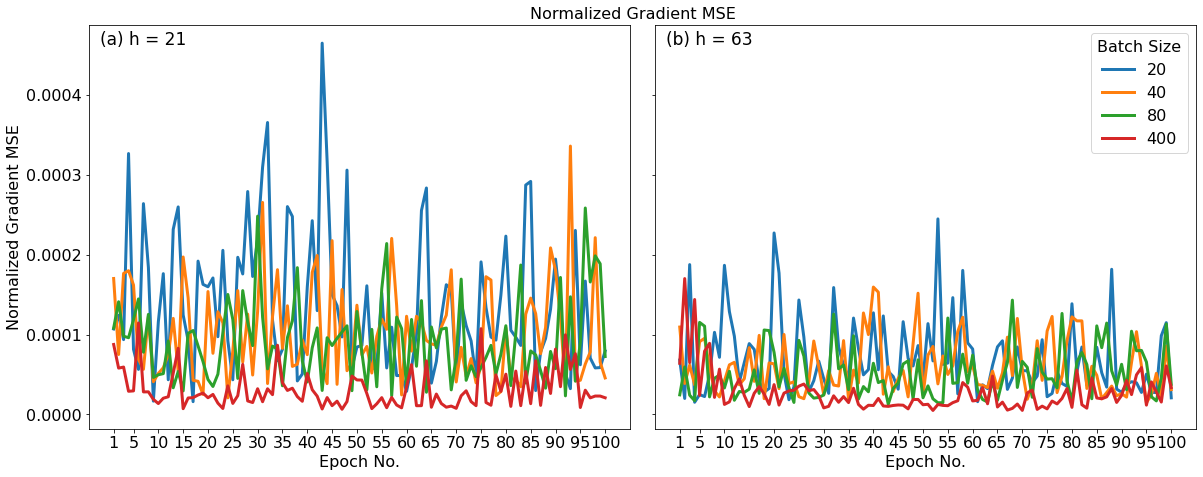

In [25]:
fig, ax = plt.subplots(1, 2, sharey = True, sharex = True)
fig.set_size_inches(16, 6)
fig.tight_layout(pad = 0)
ax[0].plot(normgrad_epoch_1 / np.sqrt(778), label = "20", linewidth = 3)
ax[0].plot(normgrad_epoch_2 / np.sqrt(778), label = "40", linewidth = 3)
ax[0].plot(normgrad_epoch_3 / np.sqrt(778), label = "80", linewidth = 3)
ax[0].plot(normgrad_epoch_4 / np.sqrt(778), label = "400", linewidth = 3)
ax[0].set_ylabel("Normalized Gradient MSE")
ax[0].set_xlabel("Epoch No.")
ax[0].text(0.02, 0.95, "(a) h = 21", size = 17, transform = ax[0].transAxes)
ax[0].set_xticks(range(4, epoch+1, 5))
ax[0].set_xticklabels(range(5, epoch+1, 5))
ax[1].plot(normgrad_epoch_5 / np.sqrt(2332), label = "20", linewidth = 3)
ax[1].plot(normgrad_epoch_6 / np.sqrt(2332), label = "40", linewidth = 3)
ax[1].plot(normgrad_epoch_7 / np.sqrt(2332), label = "80", linewidth = 3)
ax[1].plot(normgrad_epoch_8 / np.sqrt(2332), label = "400", linewidth = 3)
ax[1].text(0.02, 0.95, "(b) h = 63", size = 17, transform = ax[1].transAxes)
ax[1].set_xticks([0] + list(range(4, epoch+1, 5)))
ax[1].set_xticklabels([1] + list(range(5, epoch+1, 5)))
ax[1].set_xlabel("Epoch No.")
ax[1].legend(title = "Batch Size")

fig.text(0.5, 1, "Normalized Gradient MSE", ha = "center")

plt.show()

It can be observed that the normalized gradient MSE
1.     fluctuates more when h = 21.
2.     doesn’t show any trend of decreasing for batch size = 20, 40, or 80.
3.     has a decreasing trend and is close to 0 when batch size = 400 for both h = 21 and h = 63. However, it increases a little bit while epoch number becomes larger. 


# Normalized Root Mean Squared Error

To make the comparison much easier between different setting of h and batch size, the Normalize Root Mean Square Error are calculated as below 

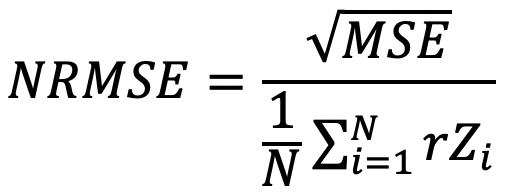

where denominator is the average of target values.

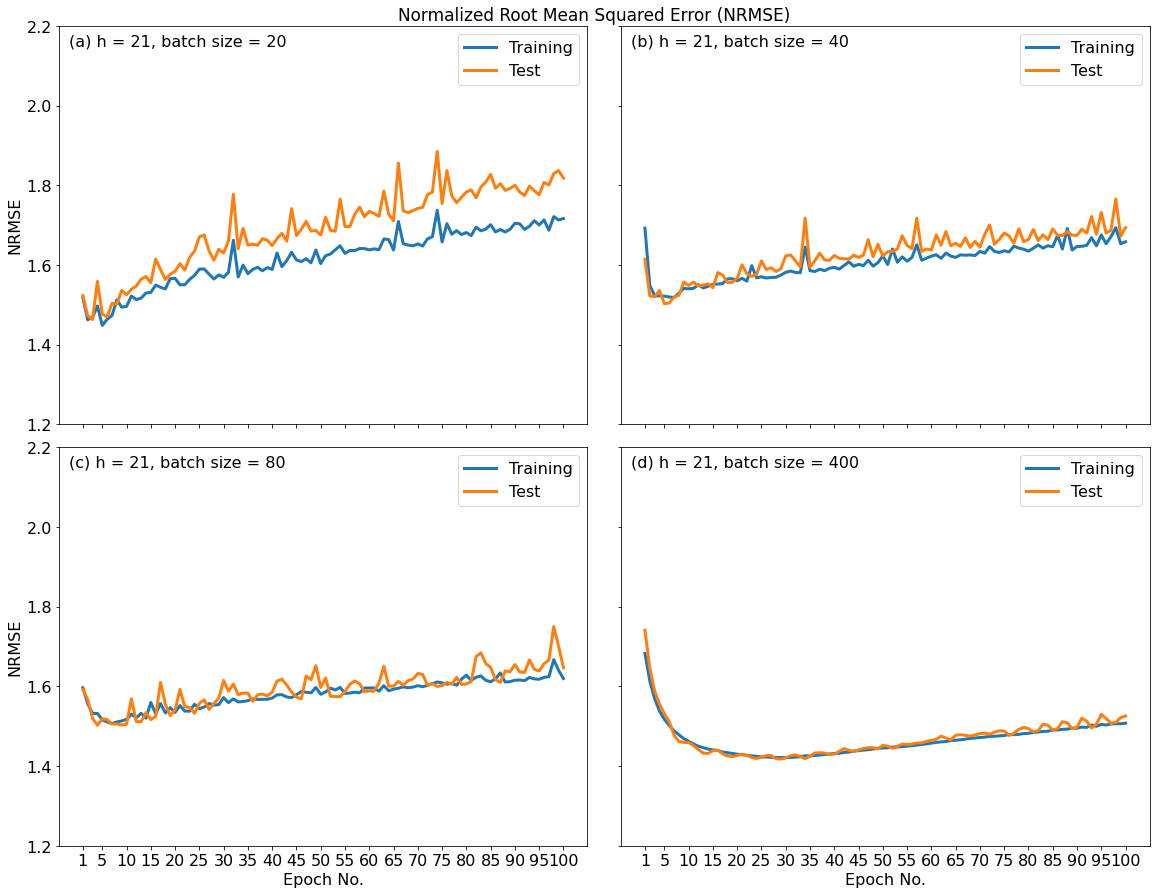

In [26]:
fig, ax = plt.subplots(2, 2, sharey = True, sharex = True)
fig.tight_layout(pad = 0.5)
ax[0][0].plot(np.sqrt(trainMSE_epoch_1) / mean_r_Z, label = "Training", linewidth = 3)
ax[0][0].plot(np.sqrt(testMSE_epoch_1) / mean_r_Z, label = "Test", linewidth = 3)
ax[0][0].text(0.02, 0.95, "(a) h = 21, batch size = 20", transform = ax[0][0].transAxes, ha = "left")
ax[0][0].set_ylabel("NRMSE")
ax[0][0].legend()
ax[0][0].set_ylim(1.2, 2.2)

ax[0][1].plot(np.sqrt(trainMSE_epoch_2) / mean_r_Z, label = "Training", linewidth = 3)
ax[0][1].plot(np.sqrt(testMSE_epoch_2) / mean_r_Z, label = "Test", linewidth = 3)
ax[0][1].text(0.02, 0.95, "(b) h = 21, batch size = 40", transform = ax[0][1].transAxes, ha = "left")
ax[0][1].legend()

ax[1][0].plot(np.sqrt(trainMSE_epoch_3) / mean_r_Z, label = "Training", linewidth = 3)
ax[1][0].plot(np.sqrt(testMSE_epoch_3) / mean_r_Z, label = "Test", linewidth = 3)
ax[1][0].text(0.02, 0.95, "(c) h = 21, batch size = 80", transform = ax[1][0].transAxes, ha = "left")
ax[1][0].legend()
ax[1][0].set_ylim(1.2, 2.2)
ax[1][0].set_ylabel("NRMSE")
ax[1][0].set_xlabel("Epoch No.")

ax[1][1].plot(np.sqrt(trainMSE_epoch_4) / mean_r_Z, label = "Training", linewidth = 3)
ax[1][1].plot(np.sqrt(testMSE_epoch_4) / mean_r_Z, label = "Test", linewidth = 3)
ax[1][1].text(0.02, 0.95, "(d) h = 21, batch size = 400", transform = ax[1][1].transAxes, ha = "left")
ax[1][1].set_xlabel("Epoch No.")
ax[1][1].set_xticks([0] + list(range(4, epoch+1, 5)))
ax[1][1].set_xticklabels([1] + list(range(5, epoch+1, 5)))
ax[1][1].legend()

fig.text(0.5, 0.99, "Normalized Root Mean Squared Error (NRMSE)", size = 17, ha = "center")

plt.show()

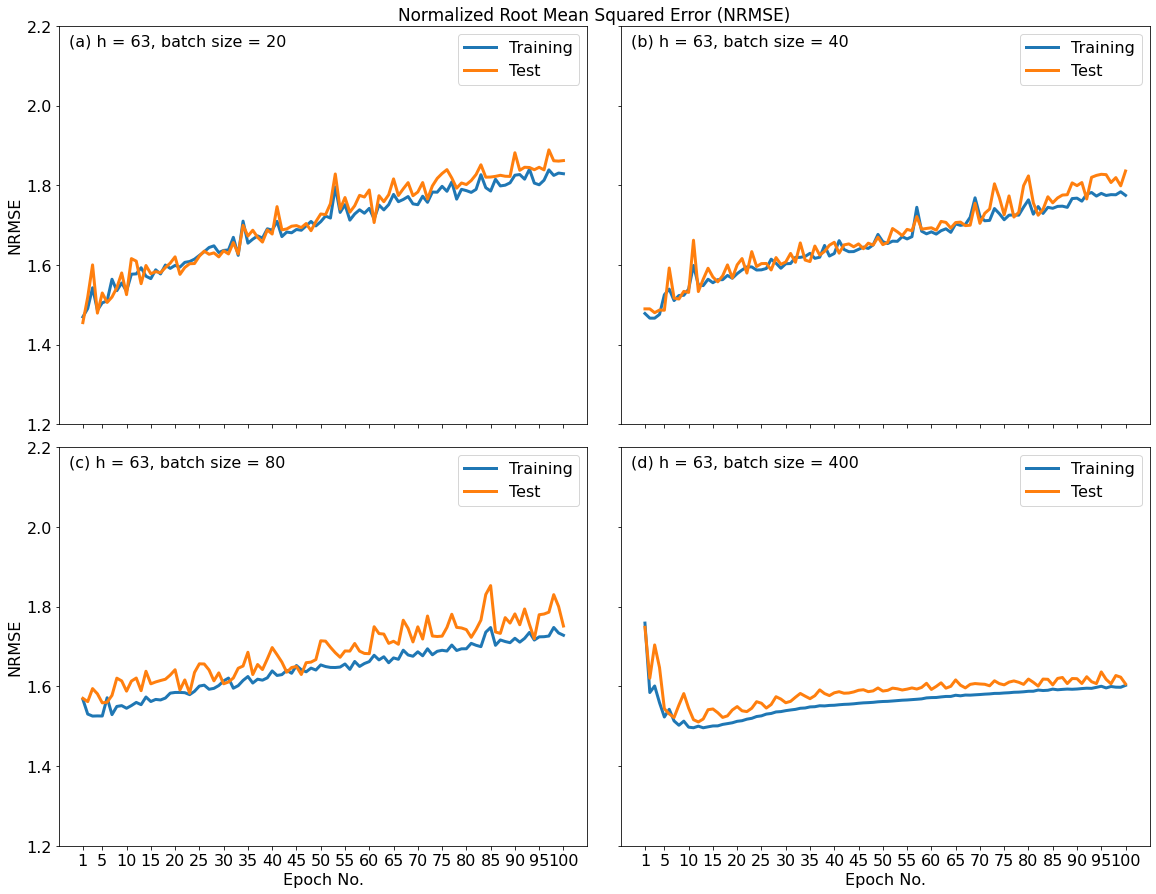

In [27]:
fig, ax = plt.subplots(2, 2, sharey = True, sharex = True)
fig.tight_layout(pad = 0.5)
ax[0][0].plot(np.sqrt(trainMSE_epoch_5) / mean_r_Z, label = "Training", linewidth = 3)
ax[0][0].plot(np.sqrt(testMSE_epoch_5) / mean_r_Z, label = "Test", linewidth = 3)
ax[0][0].text(0.02, 0.95, "(a) h = 63, batch size = 20", transform = ax[0][0].transAxes, ha = "left")
ax[0][0].set_ylabel("NRMSE")
ax[0][0].legend()
ax[0][0].set_ylim(1.2, 2.2)

ax[0][1].plot(np.sqrt(trainMSE_epoch_6) / mean_r_Z, label = "Training", linewidth = 3)
ax[0][1].plot(np.sqrt(testMSE_epoch_6) / mean_r_Z, label = "Test", linewidth = 3)
ax[0][1].text(0.02, 0.95, "(b) h = 63, batch size = 40", transform = ax[0][1].transAxes, ha = "left")
ax[0][1].legend()

ax[1][0].plot(np.sqrt(trainMSE_epoch_7) / mean_r_Z, label = "Training", linewidth = 3)
ax[1][0].plot(np.sqrt(testMSE_epoch_7) / mean_r_Z, label = "Test", linewidth = 3)
ax[1][0].text(0.02, 0.95, "(c) h = 63, batch size = 80", transform = ax[1][0].transAxes, ha = "left")
ax[1][0].legend()
ax[1][0].set_ylim(1.2, 2.2)
ax[1][0].set_ylabel("NRMSE")
ax[1][0].set_xlabel("Epoch No.")

ax[1][1].plot(np.sqrt(trainMSE_epoch_8) / mean_r_Z, label = "Training", linewidth = 3)
ax[1][1].plot(np.sqrt(testMSE_epoch_8) / mean_r_Z, label = "Test", linewidth = 3)
ax[1][1].text(0.02, 0.95, "(d) h = 63, batch size = 400", transform = ax[1][1].transAxes, ha = "left")
ax[1][1].set_xlabel("Epoch No.")
ax[1][1].set_xticks([0] + list(range(4, epoch+1, 5)))
ax[1][1].set_xticklabels([1] + list(range(5, epoch+1, 5)))
ax[1][1].legend()

fig.text(0.5, 0.99, "Normalized Root Mean Squared Error (NRMSE)", size = 17, ha = "center")

plt.show()

With the normalization, it is easier to compare between different parameters. In these figures, it can be observed that
1. h = 21 with batch size = 20 shows an overfitting condition. As the epoch goes larger, the overfitting become more severe.
2. Models with batch size = 400 have a trend of decreasing at the beginning and then at some point the MSE started to increase.
3. Both h = 21 and h = 63 show that batch size = 400 has the best NRMSE at any epoch number. 

## Pick up the optimal epoch of each model and corresponding training MSE and test MSE.

In [28]:
optimal_m_table = pd.DataFrame({"m": np.nan, "Training MSE": np.nan, "Test MSE": np.nan}, index = range(1, 9))
for i in range(8):
  temp_index = np.argmin(globals()["testMSE_epoch_" + str(i+1)])
  optimal_m_table.iloc[i, 0] = temp_index + 1
  optimal_m_table.iloc[i, 1] = globals()["trainMSE_epoch_" + str(i+1)][temp_index]
  optimal_m_table.iloc[i, 2] = globals()["testMSE_epoch_" + str(i+1)][temp_index]

optimal_m_table

,m,Training MSE,Test MSE
1,3.0,0.000081,0.000080
2,5.0,0.000087,0.000085
3,4.0,0.000088,0.000085
4,29.0,0.000076,0.000075
5,1.0,0.000081,0.000080
6,3.0,0.000081,0.000082
7,5.0,0.000087,0.000091
8,12.0,0.000085,0.000086


In conclusion, the MLP model with h = 21 and batch size = 400 has the potential to be the best MLP model among all 8 models. 

# Most Influential Neuron

After comparing among all 8 learning, the best model is decided to be with 21 hidden neurons and batch size equals to 400 at epoch = 29. 

In this section, the most influential weight that 
1. linking input layer and hidden layer
2. linking hidden layer and output layer 

will be identified.


### Weight linking input layer and hidden layer

#### Retrain the best model (h = 21 and batch size = 400) with optimal epoch = 29.

In [29]:
tf.random.set_seed(seed)
best_epoch = 29
best_pair_hyperpara = [21, 400]

best = MLP(tf.keras.optimizers.Adam(), "relu", 1, [best_pair_hyperpara[0]], best_pair_hyperpara[1], best_epoch, X_train, y_train, X_test, y_test)
para_best = best[3]
computing_time_best = best[4]
abs_weights_i_to_h = np.abs(para_best[0])
abs_weights_h_to_o = np.abs(para_best[2])

There are 35 × 21 = 735 weights between these two layers in total. 

The histogram of the absolute weight are shown as below.

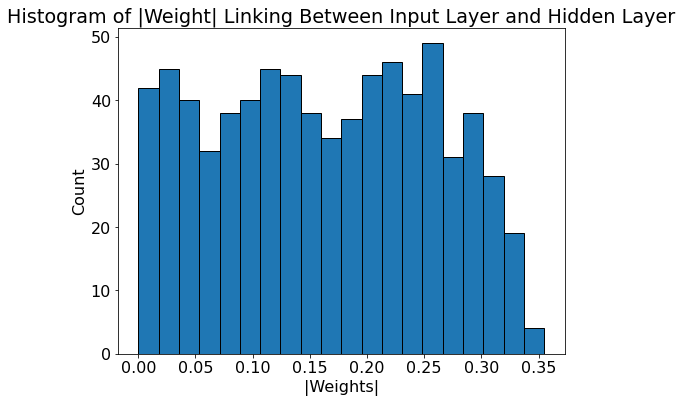

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.hist(abs_weights_i_to_h.flatten(), bins = 20, edgecolor = 'black')
ax.set_xlabel("|Weights|")
ax.set_ylabel("Count")
ax.set_title("Histogram of |Weight| Linking Between Input Layer and Hidden Layer")
plt.show()

The distribution is fairly even with several neurons have higher value of |weight|. 

#### 10 largest |weight| that connecting the input layer and the hidden layer. 

In [31]:
temp_weight = abs_weights_i_to_h.copy()
top_10_weights_i_to_h = pd.DataFrame({"From Input": np.nan, "To Neuron": np.nan, "|Weight|": np.nan}, index = range(10))

for i in range(10):
  temp_index = np.argmax(temp_weight)
  top_10_weights_i_to_h.iloc[i, 2] = temp_weight[temp_index//21, temp_index%21]
  temp_weight[temp_index//21, temp_index%21] = 0
  top_10_weights_i_to_h.iloc[i, 0] = str(temp_index//21 + 1)
  top_10_weights_i_to_h.iloc[i, 1] = str(temp_index%21 + 1)

top_10_weights_i_to_h

,From Input,To Neuron,|Weight|
0,21,13,0.354988
1,26,10,0.344428
2,18,7,0.341153
3,17,16,0.339333
4,31,14,0.336730
5,26,5,0.333244
6,31,21,0.332796
7,11,15,0.331303
8,21,7,0.330921
9,31,2,0.329601


#### 10 smallest |weight| that connecting the input layer and the hidden layer. 

In [32]:
temp_weight = abs_weights_i_to_h.copy()
last_10_weights_i_to_h = pd.DataFrame({"From Input": np.nan, "To Neuron": np.nan, "|Weight|": np.nan}, index = range(10))

for i in range(10):
  temp_index = np.argmin(temp_weight)
  last_10_weights_i_to_h.iloc[i, 2] = temp_weight[temp_index//21, temp_index%21]
  temp_weight[temp_index//21, temp_index%21] = np.inf
  last_10_weights_i_to_h.iloc[i, 0] = str(temp_index//21 + 1)
  last_10_weights_i_to_h.iloc[i, 1] = str(temp_index%21 + 1)

last_10_weights_i_to_h

,From Input,To Neuron,|Weight|
0,20,20,0.000094
1,7,14,0.000913
2,27,17,0.001083
3,12,14,0.001088
4,33,1,0.001105
5,28,3,0.001296
6,1,10,0.001612
7,7,4,0.001924
8,32,7,0.001934
9,15,9,0.002012


### Weights that linking from hidden layer to output layer

There are 21 × 1 = 21 weights between these two layers in total.

The histogram of the absolute weight are shown as below.

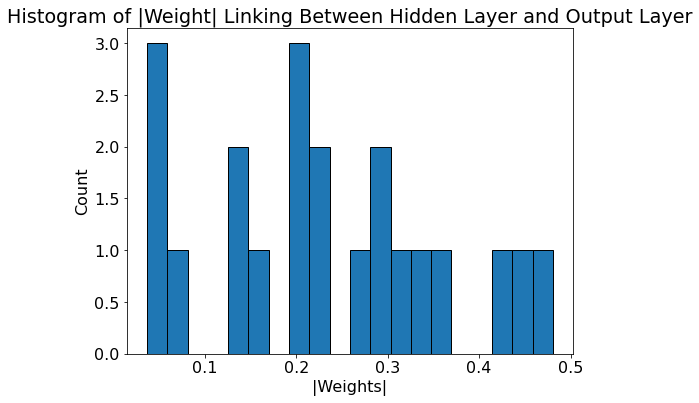

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.hist(abs_weights_h_to_o.flatten(), bins = 20, edgecolor = 'black')
ax.set_xlabel("|Weights|")
ax.set_ylabel("Count")
ax.set_title("Histogram of |Weight| Linking Between Hidden Layer and Output Layer")
plt.show()

Below chart rank the |weight| in an increasing order.

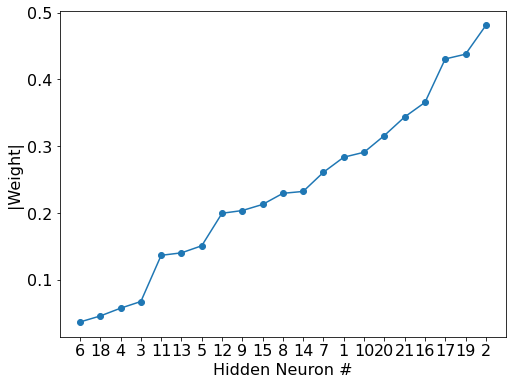

In [34]:
sort_abs_weights_h_to_o = pd.DataFrame(abs_weights_h_to_o.flatten()).sort_values(by = 0)
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(sort_abs_weights_h_to_o.values, marker = "o")
ax.set_xticks(range(21))
ax.set_xticklabels(sort_abs_weights_h_to_o.index + 1)
ax.set_xlabel("Hidden Neuron #")
ax.set_ylabel("|Weight|")
plt.show()

According to the above figure, Hidden Neuron # 2 is the most influential hidden neuron between hidden layer and output layer.

# Most Influential Explanatory Variables

Knowing that the hidden neuron #2 is strongly influential on the output. 

Thus, the most influential explanatory variable among all the 35 inputs that connect to hidden neuron #2 will be identified so that one can know which input feature is the most deterministic to the target value.

## Identify the weight that connect input layer and hidden neuron #2

In [35]:
m_i_h_n = sort_abs_weights_h_to_o.index[-1] + 1
w_c_i_and_h_n_2 = abs_weights_i_to_h[:, m_i_h_n-1]

The impact of each variable (input feature) on hidden neuron #2 is computed as below 

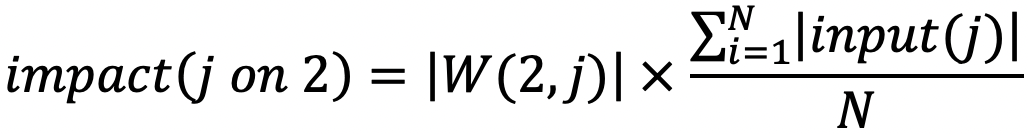

In [36]:
impact = pd.DataFrame({"Input Feature #": range(1, 36), "Impact": np.nan})
for j in range(35):
   impact.iloc[j, 1] = w_c_i_and_h_n_2[j]*np.mean(np.abs(X[:,j]))

impact = impact.sort_values(by = "Impact")

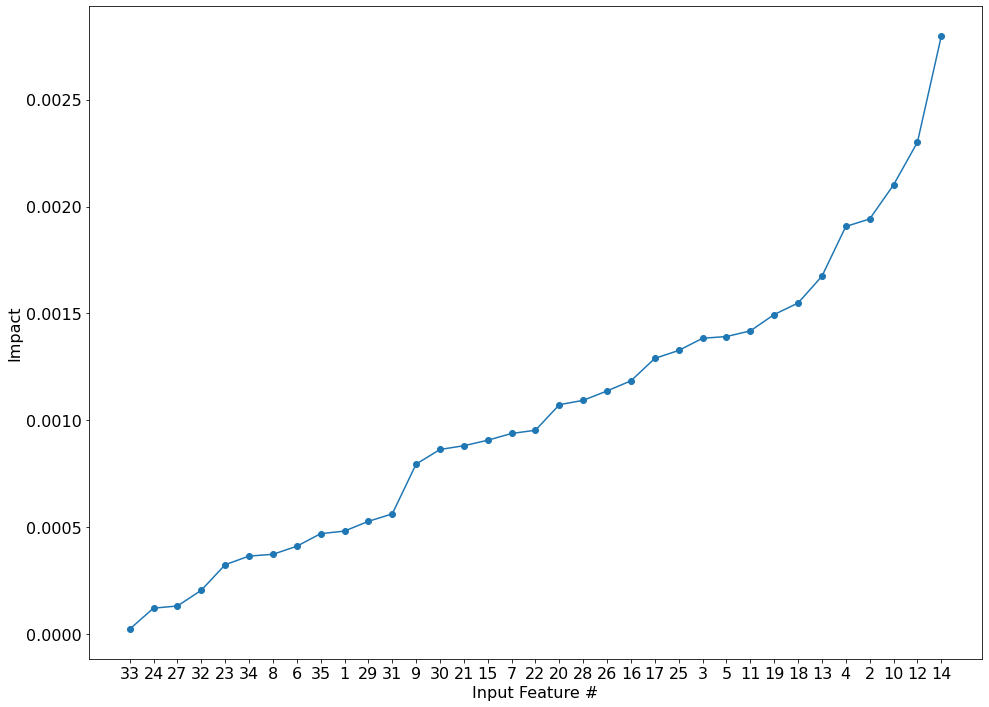

In [37]:
fig, ax = plt.subplots(1, 1, figsize = (16, 12))
ax.plot(impact["Impact"].values, marker = "o")
ax.set_xticks(range(len(impact)))
ax.set_xticklabels(impact.index + 1)
ax.set_xlabel("Input Feature #")
ax.set_ylabel("Impact")
plt.show()

In [38]:
impact.reset_index(drop = True)

,Input Feature #,Impact
0,33,0.000022
1,24,0.000120
2,27,0.000130
3,32,0.000204
4,23,0.000323
5,34,0.000364
6,8,0.000372
7,6,0.000410
8,35,0.000469
9,1,0.000481


Above table shows all the 35 input features with their associated impact on the hidden layer neuron #2. It can be observed that:
1. Input feature #14 and #12 which are the two explanatory variables have the highest influence on hidden layer neuron #2 are the SILVER prices on day t-1 and day t-3.
2. Input feature #33 and #24 which are the two explanatory variables have the lowest influence on hidden layer neuron #2 are the RMB price on day t-2 and EUR price on day t-3.

These results are aligned with our prediction that the GOLD price has more similar pattern with the raw material market than the currency or stock market.

# Improvement

There are several possible ways to improve the architecture of the MLP such as:
1. Add more hidden layers
> If the function is not complex enough, there may be an issue in underfitting the data. Increasing the number of hidden layers may lead to a more accurate representation of the data and improve the generalization. However, when adding many hidden layers, you must be aware that this can lead to overfitting which will lead to poor generalization. Computational time will also increase with the addition of more hidden layers.

2. Use different layer such as Convolution Layer, Pooling Layer, etc.
3. Try different activation function such as Sigmoid 
> A different activation function could possibly improve the model, because ReLU will output zero when given a negative input, and therefore the weights will not be updated.
4. Try different optimizer function such as SGD, Adagrad, etc. or the parameter in the optimizer function.
> For instance, if given sparse features data, Adagrad may be a more suitable optimizer function. SGD can be useful when the model seems to get stuck at a local minimum of MSE.
5. Change loss function
> In some instances, MSE as a loss function will only amplify a large error caused by a poor prediction. Mean Absolute Error (MAE) is nonnegative just like MSE but fixes the problem that arises with MSE. Huber loss is also a viable option as it has qualities that mimic both MSE and MAE.
6. Test more different number of hidden layer neuron and batch size.
> There are many possible combinations of h and BAT that have the capability of creating a better MLP model. We only tried 8 out of the enormous number of options. 

## Adding one more hidden layer

To compare with the best model with h = 21 and batch size = 400 with one hidden layer (21 neurons), we decided to add one more hidden layer with less neurons (10 neurons) behind the original hidden layer. 

In [39]:
tf.random.set_seed(seed)

improve = MLP(tf.keras.optimizers.Adam(), "relu", 2, [21, 10], 400, 100, X_train, y_train, X_test, y_test)
computing_time_improve = improve[4]
trainMSE_epoch_improve = improve[7]
testMSE_epoch_improve = improve[8]

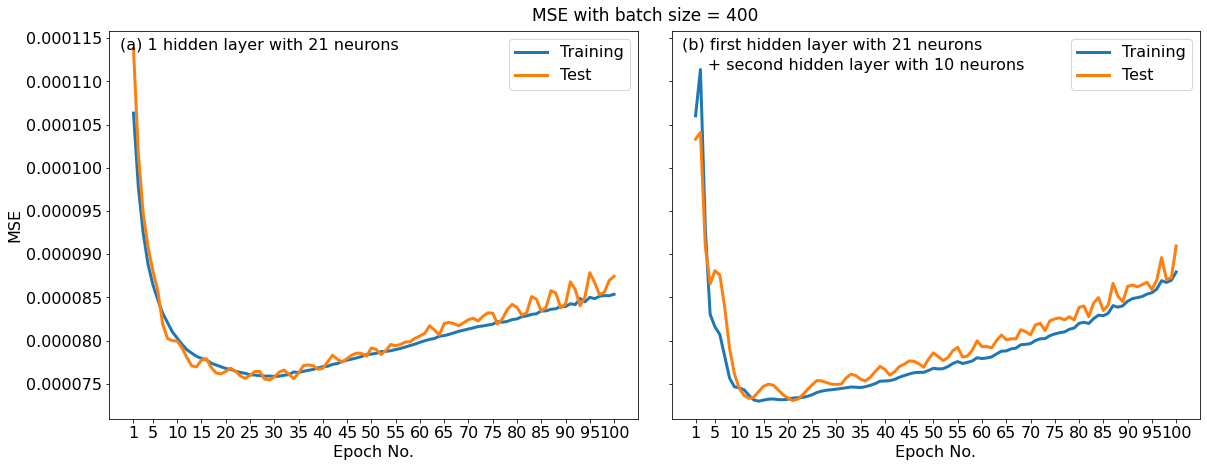

In [40]:
fig, ax = plt.subplots(1, 2, sharey = True, sharex = True)
fig.set_size_inches(16, 6)
fig.tight_layout(pad = 0.5)
ax[0].plot(trainMSE_epoch_4, label = "Training", linewidth = 3)
ax[0].plot(testMSE_epoch_4, label = "Test", linewidth = 3)
ax[0].text(0.02, 0.95, "(a) 1 hidden layer with 21 neurons", transform = ax[0].transAxes, ha = "left")
ax[0].legend()
ax[0].set_ylabel("MSE")
ax[0].set_xlabel("Epoch No.")

ax[1].plot(trainMSE_epoch_improve, label = "Training", linewidth = 3)
ax[1].plot(testMSE_epoch_improve, label = "Test", linewidth = 3)
ax[1].text(0.02, 0.95, "(b) first hidden layer with 21 neurons", transform = ax[1].transAxes, ha = "left")
ax[1].text(0.02, 0.9, "     + second hidden layer with 10 neurons", transform = ax[1].transAxes, ha = "left")
ax[1].legend()
ax[1].set_xticks([0] + list(range(4, epoch+1, 5)))
ax[1].set_xticklabels([1] + list(range(5, epoch+1, 5)))
ax[1].set_xlabel("Epoch No.")

fig.text(0.5, 0.99, "MSE with batch size = 400", size = 17, ha = "center")

plt.show()

In [41]:
best_epoch_improve = np.argmin(testMSE_epoch_improve)

tf.random.set_seed(seed)
for i in range(8):
  if i == 3:
    temp = MLP(tf.keras.optimizers.Adam(), "relu", 2, [21, 10], 400, best_epoch_improve + 1, X_train, y_train, X_test, y_test)

improve_table = pd.DataFrame({"m*": [optimal_m_table.iloc[3, 0], best_epoch_improve + 1],
                              "Computing Time (s)": [computing_time_best, computing_time_improve],
                              "Training MSE": [optimal_m_table.iloc[3, 1], temp[8][-1]],
                              "Test MSE": [optimal_m_table.iloc[3, 2], temp[7][-1]]})

improve_table

,m*,Computing Time (s),Training MSE,Test MSE
0,29.0,1.2,0.000076,0.000075
1,21.0,4.5,0.000073,0.000073


It can be observed that adding one more hidden layer can slightly decrease the MSE by around 3.3%.